In [333]:
%load_ext iminizinc
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
# import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
from decimal import *
getcontext().prec = 6
import seaborn as sns
from scipy.signal import find_peaks, peak_widths

# import mplfinance as mpf
%matplotlib inline

mpl.rcParams.update({'font.size': 5, 'lines.linewidth': 0.5, 'figure.dpi': 200, 'lines.markersize': 4})
# plt.rcParams['lines.linewidth'] = 0.5 



The iminizinc extension is already loaded. To reload it, use:
  %reload_ext iminizinc
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [357]:
exchange = 'kucoin'
pair = 'BTC_USDT'
timeframe = '4h'

odf = pd.read_json(f'../../freq-user-data/data/{exchange}/futures/{pair}-{timeframe}-futures.json').dropna()
odf.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']

odf['date'] = pd.to_datetime(odf['timestamp'], unit='ms', utc=False)
# df.index = df['time']
# df.set_index('time', drop=True, inplace=True)
odf['idate'] = odf.date.dt.strftime('%Y%m%d')
odf.set_index(pd.DatetimeIndex(odf["date"]), inplace=True, drop=True)
# df = df[['time', 'symbol', 'source', 'resolution', 'open', 'high', 'low', 'close', 'volume']]
# df.to_csv (r'./data/binance/BTC_USDT-5m.csv', index = None)
# df.set_index('time')
odf = odf.sort_index()

odf.head(8)

,timestamp,open,high,low,close,volume,date,idate
date,,,,,,,,
2020-01-01 00:00:00,1577836800000,7196.2,7243.2,7176.1,7225.4,62.743859,2020-01-01 00:00:00,20200101
2020-01-01 04:00:00,1577851200000,7225.4,7233.8,7203.1,7209.5,36.248625,2020-01-01 04:00:00,20200101
2020-01-01 08:00:00,1577865600000,7209.4,7232.0,7183.0,7195.6,52.545595,2020-01-01 08:00:00,20200101
2020-01-01 12:00:00,1577880000000,7195.7,7251.8,7195.6,7231.4,69.704852,2020-01-01 12:00:00,20200101
2020-01-01 16:00:00,1577894400000,7231.5,7248.0,7217.1,7229.0,60.889127,2020-01-01 16:00:00,20200101
2020-01-01 20:00:00,1577908800000,7229.0,7240.0,7180.0,7200.2,88.462003,2020-01-01 20:00:00,20200101
2020-01-02 00:00:00,1577923200000,7200.3,7210.6,7119.5,7125.6,106.717570,2020-01-02 00:00:00,20200102
2020-01-02 04:00:00,1577937600000,7126.2,7158.3,7104.1,7108.8,134.437394,2020-01-02 04:00:00,20200102


In [382]:
h_columns = ['open', 'high', 'low', 'close', 'volume']
ohdf = odf[h_columns].resample('1D').agg(
    OrderedDict([
        ('open', 'first'),
        ('high', 'max'),
        ('low', 'min'),
        ('close', 'last'),
        ('volume', 'sum'),
    ])
)#.set_axis([f'h_{c}' for c in h_columns], axis=1)
ohdf.head(5)

,open,high,low,close,volume
date,,,,,
2020-01-01,7196.2,7251.8,7176.1,7200.2,370.594061
2020-01-02,7200.3,7210.6,6933.3,6964.8,834.203799
2020-01-03,6964.8,7397.7,6867.0,7346.2,1325.683236
2020-01-04,7344.6,7399.0,7271.5,7355.3,695.820296
2020-01-05,7355.9,7490.0,7320.7,7359.9,948.491582


In [373]:
# odf = odf.join(hdf, how='left').ffill()

In [410]:

def plot_candles(wdf, ax=None, kwargs={}):
    # if ax is None:
    #     fig, ax = plt.subplots(**kwargs)

    up, down = wdf[wdf.close >= wdf.open], wdf[wdf.close < wdf.open]
    col1,col2 = 'green','red'
    width, width2 = 0.1, .02
    # Plotting up prices of the stock
    ax.bar(up.index, up.close-up.open, width, bottom=up.open, color=col1)
    ax.bar(up.index, up.high-up.close, width2, bottom=up.close, color=col1)
    ax.bar(up.index, up.low-up.open, width2, bottom=up.open, color=col1)
    # Plotting down prices of the stock
    ax.bar(down.index, down.close-down.open, width, bottom=down.open, color=col2)
    ax.bar(down.index, down.high-down.open, width2, bottom=down.open, color=col2)
    ax.bar(down.index, down.low-down.close, width2, bottom=down.close, color=col2)   

In [411]:
olen = odf.shape[0]

w2log = 7
wlen = 2**w2log
w2len = wlen // 2
nwin = olen // w2len 

olen, w2log, wlen, w2len, nwin

(7701, 7, 128, 64, 120)

In [412]:

### Ranges
# nest_asyncio.apply()

strategy = 'eda-wicks'
strategy_params_json = f'./par-{strategy}.json'

mpl.rcParams.update({'font.size': 5, 'lines.linewidth': 0.5, 'figure.dpi': 200})

### windowing
olen = odf.shape[0]
w2log = 7
wlen = 2**w2log
w2len = wlen // 2
nwin = olen // w2len
olen, w2log, wlen, w2len, nwin
###

sl_n2= IntSlider(description="n2", min=0, max=20, step=1, value=w2log)
sl_w = IntSlider(description="w", min=0, max=nwin, step=1, value=1)
def update_sl_w_range(*args):
    # global wlen, w2len, nwin
    wlen = 2**w2log
    w2len = wlen // 2
    nwin = olen // w2len
    # print(f'nwin = olen // w2len = {nwin}')
    sl_w.max = nwin
    sl_w.value = 0
    # wdg_inow.max = wlen
    # wdg_inow.value = wlen
sl_n2.observe(update_sl_w_range, 'value')

wdg_fu = IntSlider(value=7,min=1,max=50,step=1,description='Hold',continuous_update=False)
wdg_ema = IntSlider(value=8,min=1,max=50,step=1,description='Ema',continuous_update=False)
wdg_std = FloatText(value=0.25,min=0.1,max=5,step=0.1,description='Std',continuous_update=False)
# sl_rat = FloatRangeSlider(value=(0.02,0.05),min=0.01,max=0.2,step=0.001,description='sl_rat',continuous_update=False)
wdg_candles = Checkbox(value=True, description='Candles', disabled=False)
# dd_dir = Dropdown(options=[('Up', 1), ('Down', -1)], value=1, description='Dir',)
# wdg_pkdist = IntSlider(value=7,min=1,max=100,step=1,description='PKDist',continuous_update=False)
# wdg_inow = IntSlider(value=0,min=0,max=wlen,step=1,description='inow',continuous_update=False)
# wdg_pkprom = FloatRangeSlider(value=(0.05,1),min=0,max=1,step=0.005,description='PKProm',continuous_update=False)

strategy_params = {
    "fu": {'wdg': wdg_fu},
    "ema": {'wdg': wdg_ema},
    "std": {'wdg': wdg_std},
    "candles": {"wdg": wdg_candles},
}
all_params = {
    'w2log': {'wdg': sl_n2}, 'w': {'wdg': sl_w},
    **strategy_params
}
wdgts = [pv['wdg'] for pk, pv in all_params.items()]

ui = widgets.VBox([
    # widgets.HBox([sl_n2, sl_w]),
    widgets.VBox([widgets.HBox(wdgts[i:i+4]) for i in range(0, len(wdgts), 4)])
])

if os.path.exists(strategy_params_json):
    with open(strategy_params_json) as f: 
        js = json.loads(f.read());
        for k, v in all_params.items(): 
            if k in js: v['wdg'].value=js[k];

else: print(f'File not found: {strategy_params_json}')

wdf=None
def printer(
        w2log, w, fu, ema, std, candles
):
    global wdf    
    # global wlen, w2len, nwin
    wlen = 2**w2log
    w2len = wlen // 2
    nwin = olen // w2len

    with open(strategy_params_json, "w") as f: f.write(json.dumps({k: v['wdg'].value for k, v in strategy_params.items()}))
    
    
    wst = w * w2len
    wed = wst + wlen
    if olen - wed + 1 < w2len: wed = - 1
    print(f'wst:{wst}, wed:{wed}')
    wdf = odf.iloc[wst:wed,:].copy()    
    wlen = len(wdf)

    print(f'N={len(wdf)}; Period: {wdf.index[-1] - wdf.index[0]}, Start: {wdf.index[0]}, End: {wdf.index[-1]}\n')
    # print(f'lag_n={lag_n}; min_rat={min_rat}; max_rat={max_rat}\n')

    ### higher timeframe
    # h_columns = ['open', 'high', 'low', 'close', 'volume']
    # hdf = odf[h_columns].resample('1D').agg(
    #     OrderedDict([
    #         ('open', 'first'),
    #         ('high', 'max'),
    #         ('low', 'min'),
    #         ('close', 'last'),
    #         ('volume', 'sum'),
    #     ])
    # )#.set_axis([f'h_{c}' for c in h_columns], axis=1)
    # hdf = ohdf.copy()
    # hdf['ema'] = hdf.close.ewm(ema).mean()
    # hdf['bstd'] = hdf.close.rolling(ema).std()
    # hdf['bal'] = hdf.ema - std * hdf.bstd
    # hdf['bah'] = hdf.ema + std * hdf.bstd
    # wdf = wdf.join(hdf[['ema', 'bal', 'bah']].shift(), how='left').ffill()

    #
    wdf['ema'] = wdf.close.ewm(ema).mean()
    wdf['bstd'] = wdf.close.rolling(ema).std()
    wdf['bal'] = wdf.ema - std * wdf.bstd
    wdf['bah'] = wdf.ema + std * wdf.bstd
    ###

    ### peaks
    # peaks, peak_props = find_peaks(wdf.close[:inow], prominence=100, distance=pkdist)
    # results_half = peak_widths(wdf.close, peaks, rel_height=0.5)
    # results_full = peak_widths(wdf.close, peaks, rel_height=1)
    
    # peaks_idx = wdf.index[peaks]
    # close_peaks = wdf.loc[peaks_idx].close
    ###

    ### wick stuff
    wdf['hmax'] = wdf.high.rolling(fu).max().shift(-fu)
    wdf['hmin'] = wdf.low.rolling(fu).min().shift(-fu)
    wdf['hmax_ret'] = wdf.high.rolling(fu).max().shift(-fu).divide(wdf.close).apply(np.log)
    wdf['lmin_ret'] = -wdf.low.rolling(fu).min().shift(-fu).divide(wdf.close).apply(np.log)
    ###
    # wdf = wdf.dropna()
    fig, (ax1,ax2) = plt.subplots(2, 1, height_ratios=[2,1], sharex=True, figsize=(12,4));
     
    plt.xticks(rotation=30, ha='right')
    # if inow >= wlen: inow = wlen - 1 
    # ax1.axvline(wdf.index[inow])
    # wdf.close.plot(ax=ax1, c='b')
    wdf[['ema']].plot(ax=ax1, c='m')
    wdf.bah.plot(ax=ax1, c='m', linestyle='--')
    wdf.bal.plot(ax=ax1, c='m', linestyle='--')
    if candles: plot_candles(wdf, ax=ax1)  
    else: ax1.plot(wdf.close, lw=0.3, c='b')
    
    # wdf[['high','h_high', 'low', 'h_low']].plot(ax=ax1)
    ### peaks
    # ax1.plot(peaks_idx, close_peaks, "^", c='m', markersize=2, alpha=0.5)
    # ax1.vlines(x=peaks_idx, ymin=close_peaks - peak_props["prominences"],
    #        ymax = close_peaks, color = "C1", lw=0.2)
    # ax1.hlines(results_full[1:][0], xmin=wdf.index[results_full[1:][1].astype(int)], xmax=wdf.index[results_full[1:][2].astype(int)], color="C1", lw=0.3)
    # ax1.hlines(results_half[1:][0], xmin=wdf.index[results_half[1:][1].astype(int)], xmax=wdf.index[results_half[1:][2].astype(int)], color="C2", lw=0.3)
    ###
    # wdf.hmax.plot(ax=ax1, c='r', lw=0.4)
    # wdf.hmin.plot(ax=ax1, c='g', lw=0.4)
    # cid = fig.canvas.mpl_connect('button_press_event', onclick)
    plt.show()
    
out = widgets.interactive_output(printer, {
        **{k : v['wdg'] for k,v in all_params.items()}
    });
x = display(ui, out);



Output()

In [442]:
fu = 5
fu_columns = [('high','max'), ('low','min'), ('close','mean')]
fu_columns = [(f'fu_{c}_{f}', (c,f)) for c, f in fu_columns]
pd.DataFrame(
    {
        f'fu_{c}_{f}': getattr(wdf[c].rolling(fu),f)()
        for (fu_col, (c, f)) in fu_columns
    }, index=wdf.index
    )


,fu_high_max,fu_low_min,fu_close_mean
date,,,
2020-01-11 16:00:00,NaN,NaN,NaN
2020-01-11 20:00:00,NaN,NaN,NaN
2020-01-12 00:00:00,NaN,NaN,NaN
2020-01-12 04:00:00,NaN,NaN,NaN
2020-01-12 08:00:00,8282.4,7962.6,8096.60
...,...,...,...
2020-02-01 04:00:00,9460.1,9212.0,9367.44
2020-02-01 08:00:00,9460.1,9259.1,9370.70
2020-02-01 12:00:00,9460.1,9300.0,9377.70


In [445]:

def get_fu(wdf, fu):    
# fu = 5
    fu_columns = [('high','max'), ('low','min'), ('close','mean')]
    fu_columns = [(f'fu_{c}_{f}', (c,f)) for c, f in fu_columns]
    fudf = pd.DataFrame(
        {
            f'fu_{c}_{f}': getattr(wdf[c].rolling(fu),f)()
            for (fu_col, (c, f)) in fu_columns
        }, index=wdf.index
        ).assign(**{f'ret_{fu_col}': lambda x: x[fu_col].divide(wdf.close) - 1
            for (fu_col, (c, f)) in fu_columns

        })
    return fudf
    ###

,fu_high_max,fu_low_min,fu_close_mean,ret_fu_high_max,ret_fu_low_min,ret_fu_close_mean
date,,,,,,
2020-01-11 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-11 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-12 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-12 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-12 08:00:00,8282.4,7962.6,8096.60,-0.001751,-0.001751,-0.001751
...,...,...,...,...,...,...
2020-02-01 04:00:00,9460.1,9212.0,9367.44,-0.005485,-0.005485,-0.005485
2020-02-01 08:00:00,9460.1,9259.1,9370.70,0.002053,0.002053,0.002053
2020-02-01 12:00:00,9460.1,9300.0,9377.70,0.004381,0.004381,0.004381


In [424]:

### Ranges
# nest_asyncio.apply()

strategy = 'eda-wicks'
strategy_params_json = f'./par-{strategy}.json'

mpl.rcParams.update({'font.size': 5, 'lines.linewidth': 0.5, 'figure.dpi': 600})

strategy_params = {
    "ema":  {'wdg': IntSlider(value=8,min=1,max=50,step=1,description='Ema',continuous_update=False)},
    "std":  {'wdg': FloatText(value=0.25,min=0.1,max=5,step=0.1,description='Std',continuous_update=False)}
}


# Helper function used for visualization in the following examples
def identify_axes(ax_dict, fontsize=48):
    """
    Helper to identify the Axes in the examples below.

    Draws the label in a large font in the center of the Axes.

    Parameters
    ----------
    ax_dict : dict[str, Axes]
        Mapping between the title / label and the Axes.
    fontsize : int, optional
        How big the label should be.
    """
    kw = dict(ha="center", va="center", fontsize=fontsize, color="darkgrey")
    

    for k, ax in ax_dict.items():
        ax.text(0.5, 0.5, k, transform=ax.transAxes, **kw)


def get_fu(wdf, fu):
    fudf = pd.DataFrame(index=wdf.index)
    .assign()
        ### wick stuff
        # wdf['hmax'] = wdf.high.rolling(fu).max().shift(-fu)
        # wdf['hmin'] = wdf.low.rolling(fu).min().shift(-fu)
        # wdf['hmax_ret'] = wdf.high.rolling(fu).max().shift(-fu).divide(wdf.close).apply(np.log)
        # wdf['lmin_ret'] = -wdf.low.rolling(fu).min().shift(-fu).divide(wdf.close).apply(np.log)
        ###


def fu_printer(odf, strategy_params = {}, signal_func = None):

    ### windowing
    olen = odf.shape[0]
    w2log = 7
    wlen = 2**w2log
    w2len = wlen // 2
    nwin = olen // w2len
    olen, w2log, wlen, w2len, nwin
    ###

    def update_sl_w_range(*args):
        # global wlen, w2len, nwin
        wlen = 2**w2log
        w2len = wlen // 2
        nwin = olen // w2len
        # print(f'nwin = olen // w2len = {nwin}')
        sl_w.max = nwin
        sl_w.value = 0
        # wdg_inow.max = wlen
        # wdg_inow.value = wlen
    sl_n2.observe(update_sl_w_range, 'value')

    all_params = {
        ** {
            'w2log':    {'wdg': IntSlider(description="n2", min=0, max=20, step=1, value=w2log)}, 
            'w':        {'wdg': IntSlider(description="w", min=0, max=nwin, step=1, value=1)},
            "fu":       {'wdg': IntSlider(value=7,min=1,max=50,step=1,description='Hold',continuous_update=False)},
            "candles":  {"wdg": Checkbox(value=True, description='Candles', disabled=False)},
        },
        **strategy_params
    }
    wdgts = [pv['wdg'] for pk, pv in all_params.items()]

    ui = widgets.VBox([
        # widgets.HBox([sl_n2, sl_w]),
        widgets.VBox([widgets.HBox(wdgts[i:i+4]) for i in range(0, len(wdgts), 4)])
    ])

    if os.path.exists(strategy_params_json):
        with open(strategy_params_json) as f: 
            js = json.loads(f.read());
            for k, v in all_params.items(): 
                if k in js: v['wdg'].value=js[k];

    else: print(f'File not found: {strategy_params_json}')

    wdf=None
    def printer(
            w2log, w, fu, candles,# ema, std,
    ):
        global wdf    
        # global wlen, w2len, nwin
        wlen = 2**w2log
        w2len = wlen // 2
        nwin = olen // w2len

        with open(strategy_params_json, "w") as f: f.write(json.dumps({k: v['wdg'].value for k, v in strategy_params.items()}))
        
        
        wst = w * w2len
        wed = wst + wlen
        if olen - wed + 1 < w2len: wed = - 1
        print(f'wst:{wst}, wed:{wed}')
        wdf = odf.iloc[wst:wed,:].copy()    
        wlen = len(wdf)

        print(f'N={len(wdf)}; Period: {wdf.index[-1] - wdf.index[0]}, Start: {wdf.index[0]}, End: {wdf.index[-1]}\n')
        # print(f'lag_n={lag_n}; min_rat={min_rat}; max_rat={max_rat}\n')

        ### higher timeframe
        # h_columns = ['open', 'high', 'low', 'close', 'volume']
        # hdf = odf[h_columns].resample('1D').agg(
        #     OrderedDict([
        #         ('open', 'first'),
        #         ('high', 'max'),
        #         ('low', 'min'),
        #         ('close', 'last'),
        #         ('volume', 'sum'),
        #     ])
        # )#.set_axis([f'h_{c}' for c in h_columns], axis=1)
        # hdf = ohdf.copy()
        # hdf['ema'] = hdf.close.ewm(ema).mean()
        # hdf['bstd'] = hdf.close.rolling(ema).std()
        # hdf['bal'] = hdf.ema - std * hdf.bstd
        # hdf['bah'] = hdf.ema + std * hdf.bstd
        # wdf = wdf.join(hdf[['ema', 'bal', 'bah']].shift(), how='left').ffill()

        #
        # wdf['ema'] = wdf.close.ewm(ema).mean()
        # wdf['bstd'] = wdf.close.rolling(ema).std()
        # wdf['bal'] = wdf.ema - std * wdf.bstd
        # wdf['bah'] = wdf.ema + std * wdf.bstd
        ###

        ### peaks
        # peaks, peak_props = find_peaks(wdf.close[:inow], prominence=100, distance=pkdist)
        # results_half = peak_widths(wdf.close, peaks, rel_height=0.5)
        # results_full = peak_widths(wdf.close, peaks, rel_height=1)
        
        # peaks_idx = wdf.index[peaks]
        # close_peaks = wdf.loc[peaks_idx].close
        ###

        # wdf = wdf.dropna()

        # fig, (ax1,ax2) = plt.subplots(2, 1, height_ratios=[2,1], sharex=True, figsize=(12,4));
        fig = plt.figure(layout="constrained", figsize=(12,4))
        ax_dict = fig.subplot_mosaic("""
            AAA
            XYZ
            """,
            height_ratios=[2, 1], # width_ratios=[1, 3.5, 1],
        )
        identify_axes(ax_dict)
        plt.xticks(rotation=30, ha='right')
        axa = ax_dict['A']
        # if inow >= wlen: inow = wlen - 1 
        # ax1.axvline(wdf.index[inow])
        # wdf.close.plot(ax=ax1, c='b')
        # wdf[['ema']].plot(ax=ax1, c='m')
        # wdf.bah.plot(ax=ax1, c='m', linestyle='--')
        # wdf.bal.plot(ax=ax1, c='m', linestyle='--')
        if candles: plot_candles(wdf, ax=axa)  
        else: axa.plot(wdf.close, lw=0.3, c='b')
        
        # wdf[['high','h_high', 'low', 'h_low']].plot(ax=ax1)
        ### peaks
        # ax1.plot(peaks_idx, close_peaks, "^", c='m', markersize=2, alpha=0.5)
        # ax1.vlines(x=peaks_idx, ymin=close_peaks - peak_props["prominences"],
        #        ymax = close_peaks, color = "C1", lw=0.2)
        # ax1.hlines(results_full[1:][0], xmin=wdf.index[results_full[1:][1].astype(int)], xmax=wdf.index[results_full[1:][2].astype(int)], color="C1", lw=0.3)
        # ax1.hlines(results_half[1:][0], xmin=wdf.index[results_half[1:][1].astype(int)], xmax=wdf.index[results_half[1:][2].astype(int)], color="C2", lw=0.3)
        ###
        # wdf.hmax.plot(ax=ax1, c='r', lw=0.4)
        # wdf.hmin.plot(ax=ax1, c='g', lw=0.4)
        # cid = fig.canvas.mpl_connect('button_press_event', onclick)
        plt.show()
        
    out = widgets.interactive_output(printer, {
            **{k : v['wdg'] for k,v in all_params.items()}
        });
    x = display(ui, out);

fu_printer(odf, strategy_params = {}, signal_func = None)

Output()

In [414]:

wdf['bol'] = wdf[['open','close']].min(axis=1)
wdf['boh'] = wdf[['open','close']].max(axis=1)
wdf['wlpct'] = wdf.low.divide(wdf.bol - 1e-7).apply(np.log)
wdf['whpct'] = wdf.high.divide(wdf.boh + 1e-7).apply(np.log)

def lagged_max_wick_below(lag):
    global wdf
    for i in range(lag-1, wdf.shape[0]):
        xdf = wdf[i-lag+1:i]
        close = wdf.iloc[i].close
        # print(((xdf.close >= close) * xdf.low.divide(close + 1e-7).apply(np.log)).max())
        wdf.at[wdf.index[i],f'laWlpct_{lag}'] = ((xdf.close >= close) * xdf.low.divide(close).apply(np.log)).max()
        
    plt.subplots(figsize=(12,3))
    sns.kdeplot(wdf[f'laWlpct_{lag}'], cumulative=False)
    wdf = wdf.dropna()


interact(lagged_max_wick_below, lag=widgets.IntSlider(min=2, max=30, step=1, value=12))
# wdf.assign(twl=lambda x: (x.bol,x.low))
# wdf.laWlpct.hist(figsize=(12,5),bins=20)


interactive(children=(IntSlider(value=12, description='lag', max=30, min=2), Output()), _dom_classes=('widget-…

<function __main__.lagged_max_wick_below(lag)>

In [415]:
wdf.head(4)

,timestamp,open,high,low,close,volume,date,idate,h_open,h_high,h_low,h_close,h_volume,bol,boh,wlpct,whpct,laWlpct_12
date,,,,,,,,,,,,,,,,,,
2020-01-13 12:00:00,1578916800000,8082.0,8110.1,8061.0,8082.7,120.226107,2020-01-13 12:00:00,20200113,8184.6,8195.0,8061.0,8107.3,768.280384,8082.0,8082.7,-2.601748e-03,0.003384,0.003557
2020-01-13 16:00:00,1578931200000,8082.8,8129.7,8073.8,8109.3,120.180621,2020-01-13 16:00:00,20200113,8184.6,8195.0,8061.0,8107.3,768.280384,8082.8,8109.3,-1.114096e-03,0.002512,0.000271
2020-01-13 20:00:00,1578945600000,8109.2,8155.0,8102.3,8107.3,149.097929,2020-01-13 20:00:00,20200113,8184.6,8195.0,8061.0,8107.3,768.280384,8107.3,8109.2,-6.169184e-04,0.005632,0.000518
2020-01-14 00:00:00,1578960000000,8107.8,8484.7,8107.8,8463.6,554.250330,2020-01-14 00:00:00,20200114,8107.8,8878.4,8107.8,8819.4,3013.282530,8107.8,8463.6,1.233369e-11,0.002490,-0.000000


In [416]:

mpl.rcParams.update({'font.size': 3, 'lines.linewidth': 0.5, 'figure.dpi': 200, 'lines.markersize': 4})
fig = plt.figure(figsize=(5,3))
# fig.subplots()
# plt.scatter(wdf.laWlpct_6, np.sqrt(-wdf.lmin_ret), s=2 )
p = sns.jointplot(x=wdf.laWlpct_6, y=np.sqrt(-wdf.lmin_ret))
# p = sns.pairplot(data=wdf[['hmax_ret','laWlpct_4','laWlpct_6']], plot_kws={"s": 3})
p.fig.set_dpi(100)

plt.show()

AttributeError: 'DataFrame' object has no attribute 'laWlpct_6'

<Figure size 1000x600 with 0 Axes>

In [ ]:
# fig, ax = plt.subplots(figsize=(2,2))
# ax.set_xlim((-0.001,0.1))
# ax.axhline(0.5)
# xdf = wdf#[wdf.laWlpct_6 < -0.0014]
# sns.ecdfplot(xdf.laWlpct_12, ax=ax)
# # wdf[wdf.laWlpct_6 < 1.5].lmin_ret.hist(bins=100)
wdf.laWlpct_12.describe()

count    3836.000000
mean        0.025280
std         0.042199
min        -0.000000
25%        -0.000000
50%         0.007684
75%         0.034192
max         0.491141
Name: laWlpct_12, dtype: float64

In [ ]:

xdf = wdf[wdf.laWlpct_12 >= 0.035]
xdf[['lmin_ret','hmax_ret','laWlpct_12']].describe()
# xdf.lmin_ret.quantile(np.arange(0,1,10))
# pd.concat([xdf.lmin_ret.describe(), xdf.hmax_ret.describe()], axis=1)
# xdf.columns

,lmin_ret,hmax_ret,laWlpct_12
count,928.000000,928.000000,928.000000
mean,0.038872,0.030140,0.081785
std,0.053472,0.028725,0.053129
min,-0.000000,0.000000,0.035026
25%,0.010490,0.010368,0.047044
50%,0.024602,0.021941,0.064989
75%,0.046875,0.040424,0.099811
max,0.665113,0.214171,0.491141


<Axes: xlabel='date'>

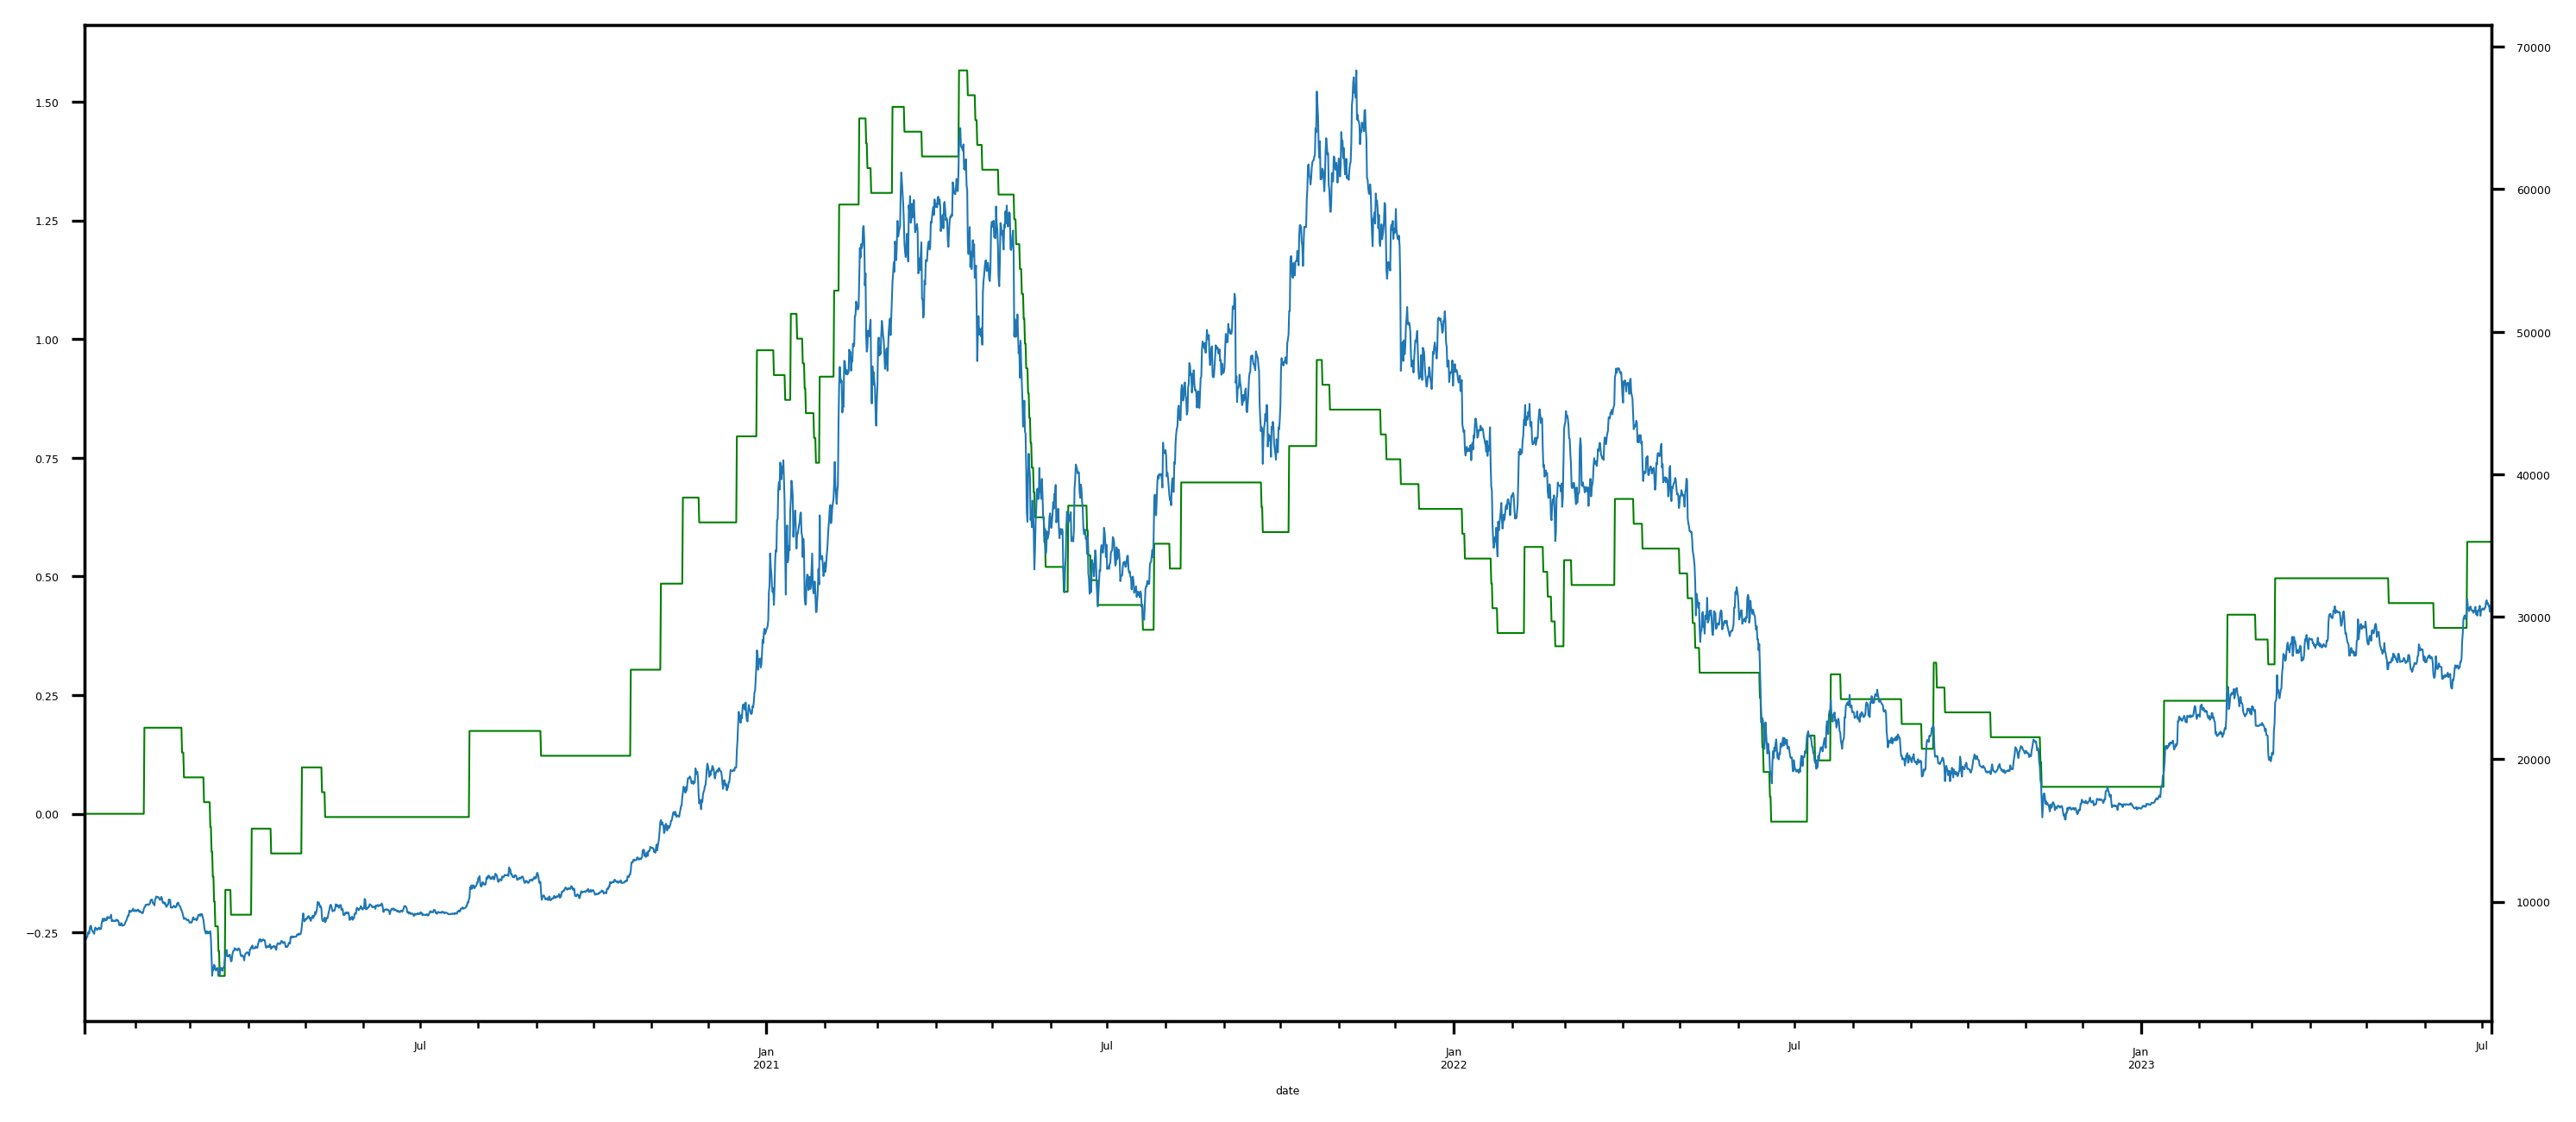

In [ ]:
sig = wdf.laWlpct_12 >= 0.02
# pct_risk = 0.2
posind = None
sl, tp, inprice = None, None, None
wdf['rpnl'] = 0
for ind, row in wdf.iterrows():
    if posind is None:
        if sig[ind]:
            sl = row.close * (1 - 0.05)
            tp = row.close * (1 + 0.2)
            inprice = row.close
            posind = ind
    else:
        # pos = pct_risk * ( (inprice - sl) / inprice) * (1 - 0.001)
        if row.low <= sl:
            wdf.at[ind, 'rpnl'] = log(sl/inprice) + log(1 - 0.001)
            posind = None
        elif row.high >= tp:
            wdf.at[ind, 'rpnl'] = log(tp/inprice) + log(1 - 0.001)
            posind = None

fig, ax1 = plt.subplots(figsize=(12,5))

wdf.rpnl.cumsum().plot(ax=ax1, c='g')
ax2 = ax1.twinx()
# ax2.plot(wdf.close)
wdf.close.plot(ax=ax2)
    # print(row['c1'], row['c2'])
# sig

In [300]:
log(1 - 0.001)

-0.0010005003335835344

In [87]:
wdf = wdf.dropna()
from sklearn.linear_model import LinearRegression
X = wdf.laWlpct_6.values.reshape(-1, 1)
Y = wdf.lmin_ret.values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
model = linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
# model.

In [88]:
model.

LinearRegression()